In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input, \
                                        BatchNormalization, Embedding, Masking, Bidirectional, Conv1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.utils import class_weight, shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBRegressor, XGBClassifier

import scipy.stats as stats
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
BATCH_SIZE = 32
EPOCHS = 300

from datetime import datetime, timedelta, date
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import shap
import pandas as pd
import numpy as np
import cx_Oracle
import pandas as pd
from sqlalchemy import create_engine
from imblearn.over_sampling import SMOTE
from collections import Counter
import shap

class Aggregate_helper:
    def __init__(self, eq_id, lookback_window, major_down_hour, alarm_table):
        self.eq_id = eq_id
        self.lookback_window = lookback_window
        self.alarm_table = alarm_table
        self.status_table = self.query_status()
        self.major_down_hour = major_down_hour
        
        ## include all status instead since further preprocessing would be performed
        ## make sure that the timeframe table is a subset of both the alarm and status table to compute major down correctly
        time1 = self.alarm_table.iloc[0]["DT_SET"]
        time2 = self.status_table.iloc[0]["TIMESTAMP_START"]
        timeend1 = self.alarm_table.iloc[len(self.alarm_table)-1]["DT_SET"]
        timeend2 = self.status_table.iloc[len(self.status_table)-1]["TIMESTAMP_START"]
        
        # give a 3 days window to ensure that the alarm and status are captured fully
        start = (max(time1, time2) + timedelta(days=3)).strftime("%d/%m/%Y") 
        end = min(timeend1, timeend2).strftime("%d/%m/%Y")
        
        self.timeframe_table = self.generate_time(start, end, 3)
        self.major_down_arr = self.major_down(self.timeframe_table, self.status_table, self.major_down_hour, 3600)
        self.aggregated_table = self.aggregate(self.timeframe_table, self.lookback_window, self.alarm_table, self.status_table)
        
        
    def generate_time(self, start_date:str, end_date:str, hour:int):
        start = datetime.strptime(start_date, '%d/%m/%Y')
        end = datetime.strptime(end_date, '%d/%m/%Y')

        dates = []
        while start<=end:
            row = [start]
            dates.append(row)
            start += timedelta(hours=hour)

        return pd.DataFrame(dates, columns=['TIMESTAMP'])
    
    def query_status(self):
        try:
            oracle_string = "oracle+cx_oracle://{username}:{password}@{hostname}:{port}/{database}"
            engine = create_engine(
                oracle_string.format(
                    username = 'TFM4CEBERUS',
                    password = 'TFM4CEBERUS',
                    hostname = 'ome-db.bth.infineon.com',
                    port = '1538',
                    database = 'ome'
                    )
                )
        except Exception as e:
            print(str(e))

        query = f"""select EQ_ID, TIMESTAMP_START, TIMESTAMP_END, DURATION, STATE_NAME, LEVEL3_NAME, LEVEL3 
                from (SELECT
                  eq.eq_id, eq.name, eq.eq_type_ident
                , data.timestamp_start,data.timestamp_end
                , ROUND((data.timestamp_end - data.timestamp_start)*24*60*60,0) AS Duration
                , data.tr25_3_status,data.tr25_4_status,data.tr25_5_status,data.eq_status
                , level5s.state_name
                , level5.state_name Level5_Name, level5.state_sign Level5
                , level4.state_name Level4_Name, level4.state_sign Level4
                , level3.state_name Level3_Name, level3.state_sign Level3
                ,mh.device
                ,mh.package,
                mh.lotid as lot,
                mh.product,
                mh.operation

                FROM OMEDATA.EQUIPMENT_STATE_HISTORY data
                , OMEADMIN.EQUIPMENT_INSTANCES eq
                , V_EQ_STATES level5s
                , OMEADMIN.DEF_STANDARD_STATEMODEL level5
                , OMEADMIN.DEF_STANDARD_STATEMODEL level4
                , OMEADMIN.DEF_STANDARD_STATEMODEL level3
                , OMEDATA.METAKEY_HISTORY mh

                WHERE data.eq_ident  = eq.eq_ident
                AND  data.eq_status = level5s.state_ident(+)
                AND level5.state_ident = data.tr25_5_status
                AND level4.state_ident = data.tr25_4_status
                AND level3.state_ident = data.tr25_3_status
                AND  data.metakey_ident =mh.ident(+)
                and data.timestamp_start > sysdate - 1050)
                where eq_id = '{self.eq_id}'
                ORDER BY TIMESTAMP_START"""

        status = pd.read_sql(query, engine)
        status.columns = map(lambda x: str(x).upper(), status.columns) 

        return status
    
    def aggregate(self, timeframe_table, lookback_window, alarm_table, status_table):
        alarm_df = pd.DataFrame()
        statename_df = pd.DataFrame()

        for idx, row in timeframe_table.iterrows():
            end = row["TIMESTAMP"]
            start = end - timedelta(hours=lookback_window)

            ## count the frequencies of each alarm
            filtered_alarm = alarm_table.loc[(alarm_table["DT_SET"] >= start) & (alarm_table["DT_SET"] <= end)]
            alarm_freq_table = filtered_alarm["Alarm ID"].value_counts().to_frame().T.reset_index(drop=True)
            alarm_df = pd.concat([alarm_df, alarm_freq_table], axis=0)

            ## count the frequencies of each statename, include everything since feature engineering would be performed
            filtered_statename = status_table.loc[(status_table["TIMESTAMP_START"] >= start) & (status_table["TIMESTAMP_START"] <= end)]
            status_freq_table = filtered_statename["STATE_NAME"].value_counts().to_frame().T.reset_index(drop=True)
            statename_df = pd.concat([statename_df, status_freq_table], axis=0)

        df = pd.concat([alarm_df, statename_df], axis=1)
        df = df.fillna(0)

        ## convert all columns from float to int
        cols = df.columns
        df[cols] = df[cols].astype(int)
        return df
        
    def major_down(self, input_df, status_table, hour, threshold):
        hour = pd.Timedelta(hours=hour)
        major_down = []

        for idx, row in input_df.iterrows():
            start = row['TIMESTAMP']
            end = start+hour
            frame = status_table[(status_table['TIMESTAMP_START']>start) & (status_table['TIMESTAMP_START']<end)]
            UD = frame.loc[frame['LEVEL3']=='UDT']

            if len(UD) == 0: #no record within this 6 hours:
                major_down.append(0)
            else:
                time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
                if any(time_diff>threshold):
                    major_down.append(1)
                else:
                    major_down.append(0)
        return np.array(major_down)

In [2]:
def train_val_test_split(training, target):
    X_train, X_val, y_train, y_val =  train_test_split(training, target, test_size=0.3, random_state=42, shuffle=True, stratify=target)
    X_val, X_test, y_val, y_test =  train_test_split(X_val, y_val, test_size=0.4, random_state=42, shuffle=True, stratify=y_val)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [3]:
import os 

all_tables = []
all_target = []

start = datetime.now()
for _, path, filename in os.walk("Data"):
    for ele in filename:
        alarm_file = ele
        eq_id = ele[:6]
        
        full_alarm = pd.read_excel(f"Data/{alarm_file}", engine='openpyxl', usecols = "B,C,D,F,M")
        equipment = Aggregate_helper(eq_id, 24, 24, full_alarm)
        
        all_tables.append(equipment.aggregated_table)
        all_target.append(equipment.major_down_arr)

end = datetime.now()
print(f"Data collection took {(end-start).seconds} seconds")

Data collection took 2172 seconds


In [4]:
# wba120_fullalarm = pd.read_excel("Data/WBA120_FullAlarm.xlsx", engine='openpyxl', usecols = "B,C,D,F,M")
# wba120 = Aggregate_helper("WBA120", 24, wba120_fullalarm)

# wba121_fullalarm = pd.read_excel("Data/WBA121_FullAlarm.xlsx", engine='openpyxl', usecols = "B,C,D,F,M")
# wba121 = Aggregate_helper("WBA121", 24, wba121_fullalarm)

# wba122_fullalarm = pd.read_excel("Data/WBA122_FullAlarm.xlsx", engine='openpyxl', usecols = "B,C,D,F,M")
# wba122 = Aggregate_helper("WBA122", 24, wba122_fullalarm)

# wba123_fullalarm = pd.read_excel("Data/WBA123_FullAlarm.xlsx", engine='openpyxl', usecols = "B,C,D,F,M")
# wba123 = Aggregate_helper("WBA123", 24, wba123_fullalarm)

# wba124_fullalarm = pd.read_excel("Data/WBA124_FullAlarm.xlsx", engine='openpyxl', usecols = "B,C,D,F,M")
# wba124 = Aggregate_helper("WBA124", 24, wba124_fullalarm)

# wba126_fullalarm = pd.read_excel("Data/WBA126_FullAlarm.xlsx", engine='openpyxl', usecols = "B,C,D,F,M")
# wba126 = Aggregate_helper("WBA126", 24, wba126_fullalarm)

# wba127_fullalarm = pd.read_excel("Data/WBA127_FullAlarm.xlsx", engine='openpyxl', usecols = "B,C,D,F,M")
# wba127 = Aggregate_helper("WBA127", 24, wba127_fullalarm)

# wba128_fullalarm = pd.read_excel("Data/WBA128_FullAlarm.xlsx", engine='openpyxl', usecols = "B,C,D,F,M")
# wba128 = Aggregate_helper("WBA128", 24, wba128_fullalarm)

# wba129_fullalarm = pd.read_excel("Data/WBA129_FullAlarm.xlsx", engine='openpyxl', usecols = "B,C,D,F,M")
# wba129 = Aggregate_helper("WBA129", 24, wba129_fullalarm)

# all_tables = [wba120.aggregated_table, wba121.aggregated_table, wba122.aggregated_table,
#               wba123.aggregated_table, wba124.aggregated_table, 
#               wba126.aggregated_table, wba127.aggregated_table, wba128.aggregated_table, wba129.aggregated_table]

# all_target = (wba120.major_down_arr, wba121.major_down_arr, wba122.major_down_arr,
#               wba123.major_down_arr, wba124.major_down_arr,
#               wba126.major_down_arr, wba127.major_down_arr, wba128.major_down_arr, wba129.major_down_arr)

In [5]:
new_training = pd.concat(all_tables, axis=0)
new_training = new_training.fillna(0)

## convert all columns from float to int
cols = new_training.columns
new_training[cols] = new_training[cols].astype(int)

new_target = np.concatenate(all_target)

print(Counter(new_target))

Counter({0: 73404, 1: 27444})


In [6]:
all_target

[array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([1, 1, 1, ..., 0, 0, 0]),
 array([1, 1, 1, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 1, 1, 1])]

In [7]:
new_training

,2,3,4,5,8,10,11,12,13,14,...,87,238,Conversion,64,70,236,91,159,131,132
0,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,0,0,0,1,0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
new_target

array([0, 0, 0, ..., 1, 1, 1])

In [9]:
#Cindy: 
#Shuffling the dataset + not balancing with SMOTE + xg boost trial
#Concatenating new_training & new_target into 1 dataframe, then shuffle the rows
sdf = new_training
sdf['y_values'] = new_target
sdf.sample(2)

,2,3,4,5,8,10,11,12,13,14,...,238,Conversion,64,70,236,91,159,131,132,y_values
0,0,0,2,1,0,1,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
shuffled_df = sdf.sample(frac=1,random_state=80)
shuffled_df.head(2)

,2,3,4,5,8,10,11,12,13,14,...,238,Conversion,64,70,236,91,159,131,132,y_values
0,0,0,0,0,0,1,6,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0,0,0,0,0,0,0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
X = shuffled_df.drop(['y_values'],axis=1)

In [17]:
y = np.array(shuffled_df.y_values)
#y = np.reshape(y,(shuffled_df.shape[0],1))
y.shape

(101328,)

In [20]:
y

array([0, 0, 0, ..., 0, 1, 0])

In [21]:
X.head(2)

,2,3,4,5,8,10,11,12,13,14,...,87,238,Conversion,64,70,236,91,159,131,132
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 45,stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70929, 137)
(30399, 137)
(70929,)
(30399,)


In [23]:
Counter(y)

Counter({0: 73711, 1: 27617})

In [24]:
Counter(y)[1]

27617

In [42]:
scale_pos_weight = Counter(y)[0]/Counter(y)[1]
scale_pos_weight

NameError: name 'y' is not defined

In [41]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train) # converting data to XGboost matrix data type
dtest = xgb.DMatrix(X_test, label=y_test)
params= {'scale_pos_weight':scale_pos_weight,
        'n_estimators':1000,
        'tree_method':'exact',
        'eval_metrics':'aucpr',
        'objective':'binary:logistic'}
progress = dict()
watchlist = [(dtrain,'train'), (dtest, 'eval')]

xgb_train_trial = xgb.train(params, dtrain=dtrain, 
                                num_boost_round=50, 
                                evals=watchlist, 
                                obj=None, feval=None, 
                                maximize=None, 
                                early_stopping_rounds=None, 
                                evals_result=progress, 
                                verbose_eval=True, 
                                )

[10:49:04] WARNING: ../src/learner.cc:573: 
Parameters: { "eval_metrics", "n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:49:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.65943	eval-logloss:0.66156
[1]	train-logloss:0.64072	eval-logloss:0.64442
[2]	train-logloss:0.62864	eval-logloss:0.63367
[3]	train-logloss:0.62073	eval-logloss:0.62664
[4]	train-logloss:0.61440	eval-logloss:0.62166
[5]	train-logloss:0.60872	eval-logloss:0.61685
[6]	train-logloss:0.60349	eval-logloss:0.61297
[7]	train-logloss:0.59990	eval-logloss:0.61051
[8]	train-logloss:0.59

In [46]:
import xgboost as xgb
from xgboost import XGBClassifier
model_xgb = XGBClassifier(scale_pos_weight=scale_pos_weight
                         ,n_estimators=1000
                         ,tree_method='exact'
                         ,objective='binary:logistic')
eval_set = [(X_train,y_train),(X_test,y_test)]
model_xgb.fit(X_train,y_train,eval_metric=["aucpr","error"],verbose=True,eval_set=eval_set)

[0]	validation_0-aucpr:0.45033	validation_0-error:0.38515	validation_1-aucpr:0.42617	validation_1-error:0.39462
[1]	validation_0-aucpr:0.47568	validation_0-error:0.38821	validation_1-aucpr:0.45068	validation_1-error:0.39758
[2]	validation_0-aucpr:0.48785	validation_0-error:0.37989	validation_1-aucpr:0.46146	validation_1-error:0.38965
[3]	validation_0-aucpr:0.49534	validation_0-error:0.37609	validation_1-aucpr:0.46909	validation_1-error:0.38856
[4]	validation_0-aucpr:0.50499	validation_0-error:0.37005	validation_1-aucpr:0.47666	validation_1-error:0.38215
[5]	validation_0-aucpr:0.51479	validation_0-error:0.36460	validation_1-aucpr:0.48531	validation_1-error:0.37653
[6]	validation_0-aucpr:0.52363	validation_0-error:0.35682	validation_1-aucpr:0.49145	validation_1-error:0.37133
[7]	validation_0-aucpr:0.53135	validation_0-error:0.35148	validation_1-aucpr:0.49581	validation_1-error:0.36722
[8]	validation_0-aucpr:0.53926	validation_0-error:0.34587	validation_1-aucpr:0.50224	validation_1-error:

[73]	validation_0-aucpr:0.70055	validation_0-error:0.25728	validation_1-aucpr:0.60392	validation_1-error:0.29912
[74]	validation_0-aucpr:0.70077	validation_0-error:0.25720	validation_1-aucpr:0.60418	validation_1-error:0.29909
[75]	validation_0-aucpr:0.70121	validation_0-error:0.25706	validation_1-aucpr:0.60443	validation_1-error:0.29853
[76]	validation_0-aucpr:0.70436	validation_0-error:0.25531	validation_1-aucpr:0.60650	validation_1-error:0.29600
[77]	validation_0-aucpr:0.70583	validation_0-error:0.25442	validation_1-aucpr:0.60747	validation_1-error:0.29524
[78]	validation_0-aucpr:0.70748	validation_0-error:0.25365	validation_1-aucpr:0.60831	validation_1-error:0.29498
[79]	validation_0-aucpr:0.71095	validation_0-error:0.25179	validation_1-aucpr:0.60977	validation_1-error:0.29386
[80]	validation_0-aucpr:0.71205	validation_0-error:0.25080	validation_1-aucpr:0.61076	validation_1-error:0.29327
[81]	validation_0-aucpr:0.71575	validation_0-error:0.24849	validation_1-aucpr:0.61291	validation

[146]	validation_0-aucpr:0.79370	validation_0-error:0.19876	validation_1-aucpr:0.65962	validation_1-error:0.25547
[147]	validation_0-aucpr:0.79511	validation_0-error:0.19776	validation_1-aucpr:0.66065	validation_1-error:0.25494
[148]	validation_0-aucpr:0.79631	validation_0-error:0.19744	validation_1-aucpr:0.66138	validation_1-error:0.25409
[149]	validation_0-aucpr:0.79655	validation_0-error:0.19735	validation_1-aucpr:0.66171	validation_1-error:0.25386
[150]	validation_0-aucpr:0.79786	validation_0-error:0.19662	validation_1-aucpr:0.66244	validation_1-error:0.25359
[151]	validation_0-aucpr:0.79899	validation_0-error:0.19587	validation_1-aucpr:0.66367	validation_1-error:0.25248
[152]	validation_0-aucpr:0.79987	validation_0-error:0.19522	validation_1-aucpr:0.66424	validation_1-error:0.25231
[153]	validation_0-aucpr:0.80035	validation_0-error:0.19481	validation_1-aucpr:0.66495	validation_1-error:0.25169
[154]	validation_0-aucpr:0.80044	validation_0-error:0.19490	validation_1-aucpr:0.66502	v

[218]	validation_0-aucpr:0.84676	validation_0-error:0.16202	validation_1-aucpr:0.69604	validation_1-error:0.22948
[219]	validation_0-aucpr:0.84697	validation_0-error:0.16192	validation_1-aucpr:0.69599	validation_1-error:0.22892
[220]	validation_0-aucpr:0.84716	validation_0-error:0.16187	validation_1-aucpr:0.69625	validation_1-error:0.22889
[221]	validation_0-aucpr:0.84739	validation_0-error:0.16177	validation_1-aucpr:0.69668	validation_1-error:0.22873
[222]	validation_0-aucpr:0.84765	validation_0-error:0.16154	validation_1-aucpr:0.69673	validation_1-error:0.22882
[223]	validation_0-aucpr:0.84804	validation_0-error:0.16115	validation_1-aucpr:0.69686	validation_1-error:0.22853
[224]	validation_0-aucpr:0.84834	validation_0-error:0.16098	validation_1-aucpr:0.69705	validation_1-error:0.22823
[225]	validation_0-aucpr:0.84901	validation_0-error:0.16005	validation_1-aucpr:0.69726	validation_1-error:0.22774
[226]	validation_0-aucpr:0.84905	validation_0-error:0.16005	validation_1-aucpr:0.69741	v

[290]	validation_0-aucpr:0.88416	validation_0-error:0.13078	validation_1-aucpr:0.72213	validation_1-error:0.20698
[291]	validation_0-aucpr:0.88521	validation_0-error:0.12988	validation_1-aucpr:0.72281	validation_1-error:0.20629
[292]	validation_0-aucpr:0.88547	validation_0-error:0.12985	validation_1-aucpr:0.72290	validation_1-error:0.20626
[293]	validation_0-aucpr:0.88582	validation_0-error:0.12951	validation_1-aucpr:0.72312	validation_1-error:0.20619
[294]	validation_0-aucpr:0.88608	validation_0-error:0.12927	validation_1-aucpr:0.72318	validation_1-error:0.20622
[295]	validation_0-aucpr:0.88672	validation_0-error:0.12875	validation_1-aucpr:0.72388	validation_1-error:0.20543
[296]	validation_0-aucpr:0.88706	validation_0-error:0.12840	validation_1-aucpr:0.72409	validation_1-error:0.20501
[297]	validation_0-aucpr:0.88729	validation_0-error:0.12807	validation_1-aucpr:0.72442	validation_1-error:0.20484
[298]	validation_0-aucpr:0.88741	validation_0-error:0.12793	validation_1-aucpr:0.72464	v

[362]	validation_0-aucpr:0.91134	validation_0-error:0.10498	validation_1-aucpr:0.74496	validation_1-error:0.18971
[363]	validation_0-aucpr:0.91148	validation_0-error:0.10478	validation_1-aucpr:0.74524	validation_1-error:0.18938
[364]	validation_0-aucpr:0.91160	validation_0-error:0.10470	validation_1-aucpr:0.74549	validation_1-error:0.18928
[365]	validation_0-aucpr:0.91167	validation_0-error:0.10464	validation_1-aucpr:0.74553	validation_1-error:0.18909
[366]	validation_0-aucpr:0.91212	validation_0-error:0.10418	validation_1-aucpr:0.74573	validation_1-error:0.18862
[367]	validation_0-aucpr:0.91245	validation_0-error:0.10371	validation_1-aucpr:0.74620	validation_1-error:0.18843
[368]	validation_0-aucpr:0.91327	validation_0-error:0.10283	validation_1-aucpr:0.74727	validation_1-error:0.18797
[369]	validation_0-aucpr:0.91387	validation_0-error:0.10206	validation_1-aucpr:0.74808	validation_1-error:0.18718
[370]	validation_0-aucpr:0.91414	validation_0-error:0.10175	validation_1-aucpr:0.74845	v

[434]	validation_0-aucpr:0.92896	validation_0-error:0.08682	validation_1-aucpr:0.76416	validation_1-error:0.17626
[435]	validation_0-aucpr:0.92906	validation_0-error:0.08669	validation_1-aucpr:0.76443	validation_1-error:0.17596
[436]	validation_0-aucpr:0.92923	validation_0-error:0.08661	validation_1-aucpr:0.76455	validation_1-error:0.17586
[437]	validation_0-aucpr:0.92938	validation_0-error:0.08651	validation_1-aucpr:0.76469	validation_1-error:0.17570
[438]	validation_0-aucpr:0.92975	validation_0-error:0.08614	validation_1-aucpr:0.76497	validation_1-error:0.17596
[439]	validation_0-aucpr:0.93011	validation_0-error:0.08576	validation_1-aucpr:0.76519	validation_1-error:0.17537
[440]	validation_0-aucpr:0.93038	validation_0-error:0.08562	validation_1-aucpr:0.76550	validation_1-error:0.17517
[441]	validation_0-aucpr:0.93039	validation_0-error:0.08551	validation_1-aucpr:0.76548	validation_1-error:0.17501
[442]	validation_0-aucpr:0.93046	validation_0-error:0.08544	validation_1-aucpr:0.76550	v

[506]	validation_0-aucpr:0.94032	validation_0-error:0.07495	validation_1-aucpr:0.77700	validation_1-error:0.16599
[507]	validation_0-aucpr:0.94061	validation_0-error:0.07464	validation_1-aucpr:0.77729	validation_1-error:0.16586
[508]	validation_0-aucpr:0.94094	validation_0-error:0.07420	validation_1-aucpr:0.77789	validation_1-error:0.16507
[509]	validation_0-aucpr:0.94114	validation_0-error:0.07388	validation_1-aucpr:0.77801	validation_1-error:0.16507
[510]	validation_0-aucpr:0.94132	validation_0-error:0.07361	validation_1-aucpr:0.77829	validation_1-error:0.16471
[511]	validation_0-aucpr:0.94136	validation_0-error:0.07371	validation_1-aucpr:0.77839	validation_1-error:0.16474
[512]	validation_0-aucpr:0.94136	validation_0-error:0.07368	validation_1-aucpr:0.77847	validation_1-error:0.16471
[513]	validation_0-aucpr:0.94139	validation_0-error:0.07362	validation_1-aucpr:0.77849	validation_1-error:0.16468
[514]	validation_0-aucpr:0.94142	validation_0-error:0.07357	validation_1-aucpr:0.77859	v

[578]	validation_0-aucpr:0.94935	validation_0-error:0.06274	validation_1-aucpr:0.78885	validation_1-error:0.15701
[579]	validation_0-aucpr:0.94939	validation_0-error:0.06270	validation_1-aucpr:0.78895	validation_1-error:0.15711
[580]	validation_0-aucpr:0.94940	validation_0-error:0.06270	validation_1-aucpr:0.78891	validation_1-error:0.15714
[581]	validation_0-aucpr:0.94941	validation_0-error:0.06275	validation_1-aucpr:0.78889	validation_1-error:0.15718
[582]	validation_0-aucpr:0.94955	validation_0-error:0.06264	validation_1-aucpr:0.78894	validation_1-error:0.15685
[583]	validation_0-aucpr:0.94962	validation_0-error:0.06260	validation_1-aucpr:0.78905	validation_1-error:0.15678
[584]	validation_0-aucpr:0.94970	validation_0-error:0.06253	validation_1-aucpr:0.78920	validation_1-error:0.15688
[585]	validation_0-aucpr:0.95003	validation_0-error:0.06181	validation_1-aucpr:0.78941	validation_1-error:0.15652
[586]	validation_0-aucpr:0.95019	validation_0-error:0.06147	validation_1-aucpr:0.78944	v

[650]	validation_0-aucpr:0.95550	validation_0-error:0.05438	validation_1-aucpr:0.79724	validation_1-error:0.15089
[651]	validation_0-aucpr:0.95552	validation_0-error:0.05438	validation_1-aucpr:0.79736	validation_1-error:0.15073
[652]	validation_0-aucpr:0.95553	validation_0-error:0.05436	validation_1-aucpr:0.79740	validation_1-error:0.15079
[653]	validation_0-aucpr:0.95557	validation_0-error:0.05424	validation_1-aucpr:0.79749	validation_1-error:0.15063
[654]	validation_0-aucpr:0.95559	validation_0-error:0.05421	validation_1-aucpr:0.79738	validation_1-error:0.15033
[655]	validation_0-aucpr:0.95560	validation_0-error:0.05420	validation_1-aucpr:0.79745	validation_1-error:0.15037
[656]	validation_0-aucpr:0.95561	validation_0-error:0.05410	validation_1-aucpr:0.79758	validation_1-error:0.15040
[657]	validation_0-aucpr:0.95580	validation_0-error:0.05394	validation_1-aucpr:0.79774	validation_1-error:0.15076
[658]	validation_0-aucpr:0.95589	validation_0-error:0.05384	validation_1-aucpr:0.79791	v

[722]	validation_0-aucpr:0.96016	validation_0-error:0.04861	validation_1-aucpr:0.80412	validation_1-error:0.14504
[723]	validation_0-aucpr:0.96018	validation_0-error:0.04861	validation_1-aucpr:0.80422	validation_1-error:0.14507
[724]	validation_0-aucpr:0.96028	validation_0-error:0.04841	validation_1-aucpr:0.80439	validation_1-error:0.14510
[725]	validation_0-aucpr:0.96028	validation_0-error:0.04837	validation_1-aucpr:0.80458	validation_1-error:0.14494
[726]	validation_0-aucpr:0.96029	validation_0-error:0.04839	validation_1-aucpr:0.80456	validation_1-error:0.14487
[727]	validation_0-aucpr:0.96030	validation_0-error:0.04834	validation_1-aucpr:0.80461	validation_1-error:0.14494
[728]	validation_0-aucpr:0.96036	validation_0-error:0.04816	validation_1-aucpr:0.80459	validation_1-error:0.14510
[729]	validation_0-aucpr:0.96036	validation_0-error:0.04816	validation_1-aucpr:0.80457	validation_1-error:0.14510
[730]	validation_0-aucpr:0.96036	validation_0-error:0.04816	validation_1-aucpr:0.80455	v

[794]	validation_0-aucpr:0.96387	validation_0-error:0.04270	validation_1-aucpr:0.81162	validation_1-error:0.13892
[795]	validation_0-aucpr:0.96399	validation_0-error:0.04266	validation_1-aucpr:0.81177	validation_1-error:0.13872
[796]	validation_0-aucpr:0.96413	validation_0-error:0.04266	validation_1-aucpr:0.81220	validation_1-error:0.13823
[797]	validation_0-aucpr:0.96417	validation_0-error:0.04256	validation_1-aucpr:0.81231	validation_1-error:0.13806
[798]	validation_0-aucpr:0.96420	validation_0-error:0.04249	validation_1-aucpr:0.81231	validation_1-error:0.13783
[799]	validation_0-aucpr:0.96432	validation_0-error:0.04235	validation_1-aucpr:0.81250	validation_1-error:0.13800
[800]	validation_0-aucpr:0.96436	validation_0-error:0.04208	validation_1-aucpr:0.81264	validation_1-error:0.13829
[801]	validation_0-aucpr:0.96439	validation_0-error:0.04206	validation_1-aucpr:0.81271	validation_1-error:0.13810
[802]	validation_0-aucpr:0.96440	validation_0-error:0.04206	validation_1-aucpr:0.81287	v

[866]	validation_0-aucpr:0.96718	validation_0-error:0.03826	validation_1-aucpr:0.81809	validation_1-error:0.13454
[867]	validation_0-aucpr:0.96718	validation_0-error:0.03823	validation_1-aucpr:0.81812	validation_1-error:0.13448
[868]	validation_0-aucpr:0.96721	validation_0-error:0.03823	validation_1-aucpr:0.81815	validation_1-error:0.13451
[869]	validation_0-aucpr:0.96722	validation_0-error:0.03816	validation_1-aucpr:0.81822	validation_1-error:0.13458
[870]	validation_0-aucpr:0.96725	validation_0-error:0.03809	validation_1-aucpr:0.81843	validation_1-error:0.13467
[871]	validation_0-aucpr:0.96736	validation_0-error:0.03795	validation_1-aucpr:0.81850	validation_1-error:0.13481
[872]	validation_0-aucpr:0.96737	validation_0-error:0.03797	validation_1-aucpr:0.81856	validation_1-error:0.13471
[873]	validation_0-aucpr:0.96748	validation_0-error:0.03793	validation_1-aucpr:0.81868	validation_1-error:0.13451
[874]	validation_0-aucpr:0.96751	validation_0-error:0.03781	validation_1-aucpr:0.81878	v

[938]	validation_0-aucpr:0.96996	validation_0-error:0.03487	validation_1-aucpr:0.82409	validation_1-error:0.12997
[939]	validation_0-aucpr:0.96996	validation_0-error:0.03485	validation_1-aucpr:0.82417	validation_1-error:0.12991
[940]	validation_0-aucpr:0.96997	validation_0-error:0.03485	validation_1-aucpr:0.82414	validation_1-error:0.12987
[941]	validation_0-aucpr:0.96997	validation_0-error:0.03479	validation_1-aucpr:0.82407	validation_1-error:0.12994
[942]	validation_0-aucpr:0.96998	validation_0-error:0.03487	validation_1-aucpr:0.82404	validation_1-error:0.12958
[943]	validation_0-aucpr:0.97005	validation_0-error:0.03489	validation_1-aucpr:0.82419	validation_1-error:0.12945
[944]	validation_0-aucpr:0.97016	validation_0-error:0.03481	validation_1-aucpr:0.82446	validation_1-error:0.12931
[945]	validation_0-aucpr:0.97021	validation_0-error:0.03463	validation_1-aucpr:0.82462	validation_1-error:0.12935
[946]	validation_0-aucpr:0.97031	validation_0-error:0.03437	validation_1-aucpr:0.82464	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.6690444291559547,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

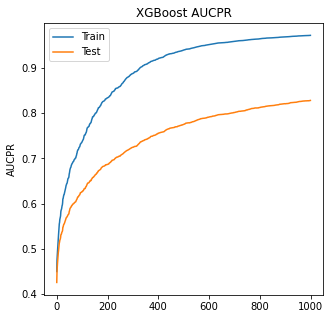

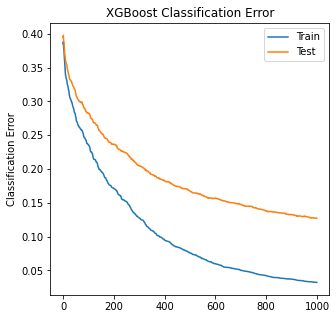

In [51]:
from matplotlib import pyplot as plt
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot AUCPR
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['aucpr'], label='Train')
ax.plot(x_axis, results['validation_1']['aucpr'], label='Test')
ax.legend()

plt.ylabel('AUCPR')
plt.title('XGBoost AUCPR')
plt.show()


# plot classification error
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()

plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [27]:
y_predict=model_xgb.predict(X_test)

In [28]:
y_predict

array([1, 1, 0, ..., 0, 1, 0])

In [29]:
y_predict.shape

(30399,)

In [30]:
result = pd.DataFrame({'real_data':y_test,'prediction':y_predict})
result

,real_data,prediction
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0
...,...,...
30394,0,0
30395,0,1
30396,0,0
30397,0,1


In [31]:
confusion_matrix(y_test,y_predict)

array([[20243,  1871],
       [ 2004,  6281]])

In [32]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print('precision score: ',precision_score(y_test,y_predict))
print('recall score: ',recall_score(y_test,y_predict))

precision score:  0.7704857703631011
recall score:  0.7581170790585395


Removing the State Name Data cos not accurate

In [29]:
only_alarm_columns = [i for i in new_training.columns if type(i)==int]
X_alarm = new_training[only_alarm_columns]
X_alarm.head(2)

,2,3,4,5,8,10,11,12,13,14,...,1,87,238,64,70,236,91,159,131,132
0,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
data_alarm = X_alarm 
data_alarm['y'] = new_target 
data_alarm.sample(2)

,2,3,4,5,8,10,11,12,13,14,...,87,238,64,70,236,91,159,131,132,y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,10,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [44]:
data_alarm['y'].value_counts()[0]

73450

In [63]:
scale_pos_weight_2 = data_alarm['y'].value_counts()[0]/data_alarm['y'].value_counts()[1]
scale_pos_weight_2

2.6730475289322366

In [64]:
train = data_alarm.iloc[0:7500]
test = data_alarm.iloc[7500:]
train_sf = train.sample(frac = 1, random_state = 40)
test_sf = test.sample(frac = 1, random_state = 30)

X_tr = train_sf.drop('y',axis=1)
X_ts = test_sf.drop('y',axis = 1)
y_tr = train_sf.y
y_ts = test_sf.y

In [65]:
import xgboost as xgb
from xgboost import XGBClassifier
model_xgb = XGBClassifier(scale_pos_weight=scale_pos_weight_2
                         ,n_estimators=500
                         ,tree_method='exact'
                         ,objective='binary:logistic')
eval_set = [(X_tr,y_tr),(X_ts,y_ts)]
model_xgb.fit(X_tr,y_tr,eval_metric=["aucpr","error"],verbose=True,eval_set=eval_set)

[0]	validation_0-aucpr:0.53790	validation_0-error:0.26653	validation_1-aucpr:0.32562	validation_1-error:0.32988
[1]	validation_0-aucpr:0.59627	validation_0-error:0.26920	validation_1-aucpr:0.34319	validation_1-error:0.35124
[2]	validation_0-aucpr:0.65522	validation_0-error:0.25560	validation_1-aucpr:0.35054	validation_1-error:0.36195
[3]	validation_0-aucpr:0.68106	validation_0-error:0.24627	validation_1-aucpr:0.34611	validation_1-error:0.36096
[4]	validation_0-aucpr:0.69039	validation_0-error:0.24013	validation_1-aucpr:0.34369	validation_1-error:0.35776
[5]	validation_0-aucpr:0.71169	validation_0-error:0.23040	validation_1-aucpr:0.34653	validation_1-error:0.35515
[6]	validation_0-aucpr:0.72893	validation_0-error:0.21987	validation_1-aucpr:0.34178	validation_1-error:0.35206
[7]	validation_0-aucpr:0.74885	validation_0-error:0.20853	validation_1-aucpr:0.33744	validation_1-error:0.35182
[8]	validation_0-aucpr:0.75282	validation_0-error:0.20693	validation_1-aucpr:0.33764	validation_1-error:

[73]	validation_0-aucpr:0.94945	validation_0-error:0.08067	validation_1-aucpr:0.31369	validation_1-error:0.34240
[74]	validation_0-aucpr:0.94961	validation_0-error:0.08040	validation_1-aucpr:0.31344	validation_1-error:0.34246
[75]	validation_0-aucpr:0.94996	validation_0-error:0.08040	validation_1-aucpr:0.31343	validation_1-error:0.34223
[76]	validation_0-aucpr:0.95101	validation_0-error:0.07827	validation_1-aucpr:0.31358	validation_1-error:0.34297
[77]	validation_0-aucpr:0.95104	validation_0-error:0.07827	validation_1-aucpr:0.31365	validation_1-error:0.34303
[78]	validation_0-aucpr:0.95104	validation_0-error:0.07813	validation_1-aucpr:0.31373	validation_1-error:0.34333
[79]	validation_0-aucpr:0.95214	validation_0-error:0.07640	validation_1-aucpr:0.31259	validation_1-error:0.34319
[80]	validation_0-aucpr:0.95271	validation_0-error:0.07547	validation_1-aucpr:0.31258	validation_1-error:0.34307
[81]	validation_0-aucpr:0.95483	validation_0-error:0.07507	validation_1-aucpr:0.31173	validation

[146]	validation_0-aucpr:0.98003	validation_0-error:0.04293	validation_1-aucpr:0.29276	validation_1-error:0.33230
[147]	validation_0-aucpr:0.98029	validation_0-error:0.04320	validation_1-aucpr:0.29292	validation_1-error:0.33225
[148]	validation_0-aucpr:0.98023	validation_0-error:0.04320	validation_1-aucpr:0.29273	validation_1-error:0.33207
[149]	validation_0-aucpr:0.98026	validation_0-error:0.04253	validation_1-aucpr:0.29289	validation_1-error:0.33242
[150]	validation_0-aucpr:0.98052	validation_0-error:0.04240	validation_1-aucpr:0.29260	validation_1-error:0.33188
[151]	validation_0-aucpr:0.98077	validation_0-error:0.04200	validation_1-aucpr:0.29253	validation_1-error:0.33113
[152]	validation_0-aucpr:0.98124	validation_0-error:0.04107	validation_1-aucpr:0.29262	validation_1-error:0.33203
[153]	validation_0-aucpr:0.98161	validation_0-error:0.04080	validation_1-aucpr:0.29249	validation_1-error:0.33138
[154]	validation_0-aucpr:0.98194	validation_0-error:0.04080	validation_1-aucpr:0.29231	v

[218]	validation_0-aucpr:0.98683	validation_0-error:0.03107	validation_1-aucpr:0.28687	validation_1-error:0.32748
[219]	validation_0-aucpr:0.98694	validation_0-error:0.03080	validation_1-aucpr:0.28702	validation_1-error:0.32763
[220]	validation_0-aucpr:0.98698	validation_0-error:0.03067	validation_1-aucpr:0.28692	validation_1-error:0.32751
[221]	validation_0-aucpr:0.98703	validation_0-error:0.03080	validation_1-aucpr:0.28679	validation_1-error:0.32770
[222]	validation_0-aucpr:0.98701	validation_0-error:0.03080	validation_1-aucpr:0.28673	validation_1-error:0.32759
[223]	validation_0-aucpr:0.98704	validation_0-error:0.03040	validation_1-aucpr:0.28669	validation_1-error:0.32807
[224]	validation_0-aucpr:0.98705	validation_0-error:0.03027	validation_1-aucpr:0.28674	validation_1-error:0.32778
[225]	validation_0-aucpr:0.98707	validation_0-error:0.03027	validation_1-aucpr:0.28674	validation_1-error:0.32779
[226]	validation_0-aucpr:0.98706	validation_0-error:0.03027	validation_1-aucpr:0.28707	v

[290]	validation_0-aucpr:0.98919	validation_0-error:0.02627	validation_1-aucpr:0.28390	validation_1-error:0.32440
[291]	validation_0-aucpr:0.98919	validation_0-error:0.02627	validation_1-aucpr:0.28438	validation_1-error:0.32443
[292]	validation_0-aucpr:0.98922	validation_0-error:0.02600	validation_1-aucpr:0.28461	validation_1-error:0.32474
[293]	validation_0-aucpr:0.98922	validation_0-error:0.02600	validation_1-aucpr:0.28482	validation_1-error:0.32467
[294]	validation_0-aucpr:0.98930	validation_0-error:0.02600	validation_1-aucpr:0.28479	validation_1-error:0.32476
[295]	validation_0-aucpr:0.98929	validation_0-error:0.02600	validation_1-aucpr:0.28477	validation_1-error:0.32470
[296]	validation_0-aucpr:0.98931	validation_0-error:0.02573	validation_1-aucpr:0.28499	validation_1-error:0.32420
[297]	validation_0-aucpr:0.98935	validation_0-error:0.02573	validation_1-aucpr:0.28499	validation_1-error:0.32389
[298]	validation_0-aucpr:0.98938	validation_0-error:0.02573	validation_1-aucpr:0.28518	v

[362]	validation_0-aucpr:0.99023	validation_0-error:0.02360	validation_1-aucpr:0.28097	validation_1-error:0.32367
[363]	validation_0-aucpr:0.99024	validation_0-error:0.02360	validation_1-aucpr:0.28093	validation_1-error:0.32410
[364]	validation_0-aucpr:0.99024	validation_0-error:0.02347	validation_1-aucpr:0.28107	validation_1-error:0.32404
[365]	validation_0-aucpr:0.99026	validation_0-error:0.02347	validation_1-aucpr:0.28098	validation_1-error:0.32409
[366]	validation_0-aucpr:0.99026	validation_0-error:0.02360	validation_1-aucpr:0.28078	validation_1-error:0.32417
[367]	validation_0-aucpr:0.99026	validation_0-error:0.02360	validation_1-aucpr:0.28071	validation_1-error:0.32436
[368]	validation_0-aucpr:0.99029	validation_0-error:0.02360	validation_1-aucpr:0.28077	validation_1-error:0.32444
[369]	validation_0-aucpr:0.99029	validation_0-error:0.02347	validation_1-aucpr:0.28071	validation_1-error:0.32433
[370]	validation_0-aucpr:0.99029	validation_0-error:0.02333	validation_1-aucpr:0.28096	v

[434]	validation_0-aucpr:0.99048	validation_0-error:0.02333	validation_1-aucpr:0.28113	validation_1-error:0.32380
[435]	validation_0-aucpr:0.99048	validation_0-error:0.02333	validation_1-aucpr:0.28113	validation_1-error:0.32413
[436]	validation_0-aucpr:0.99045	validation_0-error:0.02333	validation_1-aucpr:0.28124	validation_1-error:0.32401
[437]	validation_0-aucpr:0.99045	validation_0-error:0.02333	validation_1-aucpr:0.28125	validation_1-error:0.32414
[438]	validation_0-aucpr:0.99045	validation_0-error:0.02333	validation_1-aucpr:0.28106	validation_1-error:0.32406
[439]	validation_0-aucpr:0.99045	validation_0-error:0.02333	validation_1-aucpr:0.28102	validation_1-error:0.32405
[440]	validation_0-aucpr:0.99045	validation_0-error:0.02333	validation_1-aucpr:0.28092	validation_1-error:0.32408
[441]	validation_0-aucpr:0.99048	validation_0-error:0.02320	validation_1-aucpr:0.28087	validation_1-error:0.32394
[442]	validation_0-aucpr:0.99048	validation_0-error:0.02333	validation_1-aucpr:0.28079	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.6730475289322366,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

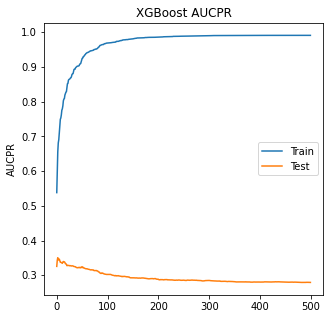

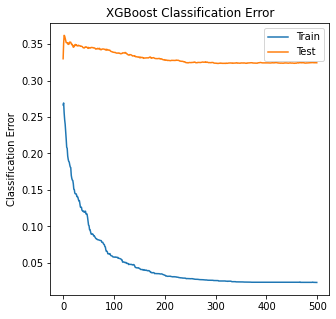

In [66]:
from matplotlib import pyplot as plt
# retrieve performance metrics
results = model_xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot AUCPR
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['aucpr'], label='Train')
ax.plot(x_axis, results['validation_1']['aucpr'], label='Test')
ax.legend()

plt.ylabel('AUCPR')
plt.title('XGBoost AUCPR')
plt.show()


# plot classification error
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()

plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [67]:
y_predict=model_xgb.predict(X_ts)
print(confusion_matrix(y_ts,y_predict))
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print('precision score: ',precision_score(y_ts,y_predict))
print('recall score: ',recall_score(y_ts,y_predict))

[[57589 10476]
 [19827  5536]]
precision score:  0.34574069447914063
recall score:  0.21827070930095022


Kai Cong's

In [5]:
oversample = SMOTE()
smote_X, smote_y = oversample.fit_resample(new_training.values, new_target)
print(Counter(smote_y))

Counter({0: 85647, 1: 29531})
Counter({0: 85647, 1: 85647})


In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(smote_X, smote_y)

In [7]:
dt_model = DecisionTreeClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)

models = [rf_model, dt_model, xgb_model]
for model in models:
    start = datetime.now()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    end = datetime.now()
    print(f"Training took {(end-start).seconds} seconds")
    print(confusion_matrix(y_test, pred))
    print(f"Prediction Accuracy for {type(model).__name__} is {accuracy_score(y_test, pred)}")

Training took 21 seconds
[[9445  833]
 [ 984 9294]]
Prediction Accuracy for RandomForestClassifier is 0.91160731659856
Training took 2 seconds
[[8686 1592]
 [1992 8286]]
Prediction Accuracy for DecisionTreeClassifier is 0.8256470130375559
[12:47:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training took 15 seconds
[[7733 2545]
 [2013 8265]]
Prediction Accuracy for XGBClassifier is 0.7782642537458649


In [ ]:
top_features_index = np.argsort(rf_model.feature_importances_)[:10]
new_training.columns[top_features_index]

# Check would accuracy drop when more EQ is slowly added one by one

In [4]:
df = pd.DataFrame(columns=all_tables[0].columns)
eq = ["WBA120", "WBA121", "WBA122", "WBA123",
      "WBA124", "WBA125", "WBA126", "WBA127", 
      "WBA128", "WBA129", "WBA130", "WBA131", 
      "WBA132", "WBA133", "WBA134", "WBA135", 
      "WBA136", "WBA137", "WBA138"]
df_target = []
accuracy = []
important_features = []

for i in range(len(all_tables)):
    table = all_tables[i]
    # slowly add equipment one by one
    old_columns = df.columns
    df = pd.concat([df, table], axis=0)
    new_columns = df.columns
    print(f"Newly added columns from equipment {eq[i]} are: {set(new_columns)-set(old_columns)}")
    
    ## convert all columns from float to int
    df = df.fillna(0)
    cols = df.columns
    df[cols] = df[cols].astype(int)
    
    # concatenate the target values as well
    df_target = np.concatenate((df_target, all_target[i]))
    oversample = SMOTE()
    smote_X, smote_y = oversample.fit_resample(df.values, df_target)
    
    # test train split and fit data to model
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(smote_X, smote_y)
    
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_train, y_train)
    pred = rf_model.predict(X_test)
    accuracy.append(accuracy_score(y_test, pred))
    
    top_features_index = np.argsort(rf_model.feature_importances_)[:10]
    important_col = df.columns[top_features_index]
    important_features.append(important_col)

    print(confusion_matrix(y_test, pred))
    print(f"Prediction Accuracy is {accuracy_score(y_test, pred)} \n\n")

Newly added columns from equipment WBA120 are: set()
[[169  10]
 [  1 177]]
Prediction Accuracy is 0.969187675070028 


Newly added columns from equipment WBA121 are: {'STITCH BOND PLACEMENT', 'Utility Problem', 49, 147, 'TIGHT WIRE', 'QA Sampling', 25}
[[294  11]
 [  1 304]]
Prediction Accuracy is 0.980327868852459 


Newly added columns from equipment WBA122 are: {9, 75, 'NO BALL SIZE', 'APC Output Violation', 'SAGGING WIRE', 'No Operator', 'Maintenance', 'Waiting For Spares', 'APC Input Violation'}
[[446  30]
 [  3 473]]
Prediction Accuracy is 0.9653361344537815 


Newly added columns from equipment WBA123 are: {'Break down Maintenance', 6, 'Engineering ME', 73, 'NoClamp&Paddle', 'Waiting for Setup', 'PC Conform', 18, 19, 'Yearly PM', 146, 244, 'Internal Particle Bridging', 'High temp tape', 'LOADER/UNLOADER PROBLEM'}
[[1237  102]
 [  87 1251]]
Prediction Accuracy is 0.9293985805005603 


Newly added columns from equipment WBA124 are: {'MC Banned', 233}
[[2067  135]
 [ 149 2052]]
Pr

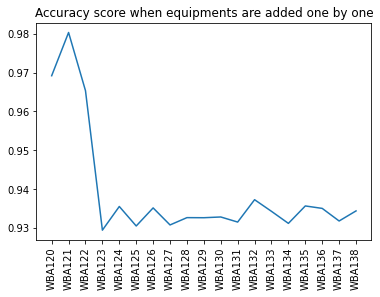

In [5]:
# plot the accuracy score
import matplotlib.pyplot as plt 
plt.plot(eq, accuracy)
plt.title("Accuracy score when equipments are added one by one")
plt.xticks(rotation=90)
plt.show()

# check the feature importances for each round of addition
df_importances = pd.DataFrame(columns=["important Features"])

In [13]:
r = permutation_importance(rf_model, X_test, y_test, n_repeats=5, n_jobs=-1, random_state=0, scoring='f1')
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{new_training.columns[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Normal Production0.109 +/- 0.002
46      0.087 +/- 0.002
Non LIFTED STICK BOND0.083 +/- 0.002
NSOP/NSOL0.079 +/- 0.001
45      0.065 +/- 0.002
Visual Inspection0.056 +/- 0.001
Waiting For Repair0.041 +/- 0.001
33      0.041 +/- 0.001
28      0.041 +/- 0.002
PC Buyoff0.037 +/- 0.001
44      0.034 +/- 0.001
24      0.029 +/- 0.001
WIRE BREAK0.026 +/- 0.001
PC Buyoff Passed0.025 +/- 0.001
No Material0.023 +/- 0.001
11      0.021 +/- 0.001
Waiting For Technician0.020 +/- 0.000
12      0.019 +/- 0.001
Change Wire0.019 +/- 0.001
SHORT TAIL0.018 +/- 0.001
Change Device0.015 +/- 0.001
151     0.013 +/- 0.000
10      0.013 +/- 0.001
Waiting For Response0.013 +/- 0.001
PlanIdle0.013 +/- 0.001
Waiting for Setup0.010 +/- 0.001
Waiting For Operator0.008 +/- 0.001
Surveillance0.008 +/- 0.000
73      0.007 +/- 0.001
Temperature Checking0.007 +/- 0.000
47      0.007 +/- 0.001
80      0.007 +/- 0.001
5       0.006 +/- 0.000
89      0.006 +/- 0.000
20      0.006 +/- 0.000
Non Schedule Time0.005 +/- 0.00

In [14]:
explainer = shap.TreeExplainer(rf_model)

In [ ]:
shap_values = explainer.shap_values(X_test)

In [ ]:
# collect data for 120 121, and predict on others
# use this model to predict other EQ family


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, \
                                    Input, Embedding, Masking, Bidirectional, Conv1D, Flatten                  
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.utils import class_weight, shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")
BATCH_SIZE = 32
EPOCHS = 300

from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import cx_Oracle
import pandas as pd
from sqlalchemy import create_engine

class seven_days_LSTM:
    def __init__(self, eq_id, alarm_table, hour_horizontal, hour_vertical):
        self.eq_id = eq_id
        self.alarm_table = alarm_table
        self.status_table = self.query_status()
        self.hour_horizontal = hour_horizontal
        self.hour_vertical = hour_vertical
        
        status_start = self.status_table.iloc[0]["TIMESTAMP_START"].date() + timedelta(days=1)
        status_end = self.status_table.iloc[len(self.status_table)-1]["TIMESTAMP_START"].date()
        alarm_start = self.alarm_table.iloc[0]["DT_SET"].date() + timedelta(days=1) # add one day to make it start from 00:00:00
        alarm_end = self.alarm_table.iloc[len(self.alarm_table)-1]["DT_SET"].date()
        self.start_date = max(status_start, alarm_start)
        self.end_date = min(status_end, alarm_end)
        
        self.timeframe_table = self.generate_time(self.start_date.strftime("%d/%m/%Y"), self.end_date.strftime("%d/%m/%Y"), \
                                                  self.hour_horizontal, self.hour_vertical)
        
        self.major_down_arr = self.major_down(self.timeframe_table, self.status_table, 6, 3600)

        self.X_seq = self.alarm_breakdown_pattern(self.timeframe_table, self.alarm_table, self.status_table, self.hour_horizontal)
        
    def generate_time(self, start_date:str, end_date:str, hours_row:int, hour:int):
        start = datetime.strptime(start_date, '%d/%m/%Y')
        end = datetime.strptime(end_date, '%d/%m/%Y')

        dates = []
        while start+timedelta(hours=hours_row)<=end:
            row = [start, start+timedelta(hours=hours_row)]
            dates.append(row)
            start += timedelta(hours=hour)

        return pd.DataFrame(dates, columns=['TIMESTAMP_START', 'TIMESTAMP_END'])

    
    def alarm_breakdown_pattern(self, datetime_table, alarm_table, status_table, hour):
        ORIG_ALARMS = []
        
        #validate alarm table date
        if alarm_table.iloc[0]['DT_SET'] < status_table.iloc[0]['TIMESTAMP_START'] or \
            alarm_table.iloc[len(alarm_table)-1]['DT_SET'] > status_table.iloc[len(status_table)-1]['TIMESTAMP_START']:
            raise ValueError("Alarm table date must be within the range of status table date")

        for idx, row in datetime_table.iterrows():
            start = row['TIMESTAMP_START']
            end = row['TIMESTAMP_END']

            table = alarm_table[(alarm_table['DT_SET']>=start) & (alarm_table['DT_SET']<=end)]
            new_table = table[["Alarm ID"]]
            
            tmp2 = []
            for n in new_table.values: # this part is needed to achieve the data structure in X_seq, else it would fail
                tmp2.append(n[0])
            ORIG_ALARMS.append(tmp2)

        return np.array(ORIG_ALARMS)
    
    def query_status(self):
        try:
            oracle_string = "oracle+cx_oracle://{username}:{password}@{hostname}:{port}/{database}"
            engine = create_engine(
                oracle_string.format(
                    username = 'TFM4CEBERUS',
                    password = 'TFM4CEBERUS',
                    hostname = 'ome-db.bth.infineon.com',
                    port = '1538',
                    database = 'ome'
                    )
                )
        except Exception as e:
            print(str(e))

        query = f"""select EQ_ID, TIMESTAMP_START, TIMESTAMP_END, DURATION, LEVEL3_NAME, LEVEL3 
                from (SELECT
                  eq.eq_id, eq.name, eq.eq_type_ident
                , data.timestamp_start,data.timestamp_end
                , ROUND((data.timestamp_end - data.timestamp_start)*24*60*60,0) AS Duration
                , data.tr25_3_status,data.tr25_4_status,data.tr25_5_status,data.eq_status
                , level5s.state_name
                , level5.state_name Level5_Name, level5.state_sign Level5
                , level4.state_name Level4_Name, level4.state_sign Level4
                , level3.state_name Level3_Name, level3.state_sign Level3
                ,mh.device
                ,mh.package,
                mh.lotid as lot,
                mh.product,
                mh.operation

                FROM OMEDATA.EQUIPMENT_STATE_HISTORY data
                , OMEADMIN.EQUIPMENT_INSTANCES eq
                , V_EQ_STATES level5s
                , OMEADMIN.DEF_STANDARD_STATEMODEL level5
                , OMEADMIN.DEF_STANDARD_STATEMODEL level4
                , OMEADMIN.DEF_STANDARD_STATEMODEL level3
                , OMEDATA.METAKEY_HISTORY mh

                WHERE data.eq_ident  = eq.eq_ident
                AND  data.eq_status = level5s.state_ident(+)
                AND level5.state_ident = data.tr25_5_status
                AND level4.state_ident = data.tr25_4_status
                AND level3.state_ident = data.tr25_3_status
                AND  data.metakey_ident =mh.ident(+)
                and data.timestamp_start > sysdate - 1500)
                where eq_id = '{self.eq_id}'
                ORDER BY TIMESTAMP_START"""

        status = pd.read_sql(query, engine)
        status.columns = map(lambda x: str(x).upper(), status.columns) 

        return status

    def major_down(self, input_table, status_table, hour, threshold):
        hour = pd.Timedelta(hours=hour)
        major_down = []
        
        # timeframe table must be a subset of the status table to correctly determine major down
        if status_table.iloc[0]["TIMESTAMP_START"] > input_table.iloc[0]["TIMESTAMP_START"]:
            raise Exception("Timeframe table must be a subset of the status table")
        if status_table.iloc[len(status_table)-1]["TIMESTAMP_START"] <= input_table.iloc[len(input_table)-1]["TIMESTAMP_START"]:
            raise Exception("Timeframe table must be a subset of the status table")   
            
        for idx, row in input_table.iterrows():
            start = row['TIMESTAMP_END']
            end = start+hour
            frame = status_table[(status_table['TIMESTAMP_START']>start) & (status_table['TIMESTAMP_START']<end)]
            UD = frame.loc[frame['LEVEL3']=='UDT']

            if len(UD) == 0: #no record within this 6 hours:
                major_down.append(0)
            else:
                time_diff = (UD['TIMESTAMP_END']-UD['TIMESTAMP_START']).dt.seconds
                if any(time_diff>threshold):
                    major_down.append(1)
                else:
                    major_down.append(0)
        return major_down

In [3]:
def label_encode(X_seq): # do this the manual way as we are not certain if sklearn LabelEncoder can handle 3D array
    all_unique_alarms = [set(ele) for ele in X_seq]
    unique_alarms = set()
    for ele in all_unique_alarms:
        unique_alarms |= ele
    
    enc_label = 1  #start encoding from 1 as we have to pad the sequence with 0
    mapping_dict = {}
    for ele in unique_alarms:
        mapping_dict[ele] = enc_label
        enc_label += 1

        enc_array = []
        
    #X_seq is a 3D array
    for timestamp in X_seq:
        tmp_arr = []
        for ele in timestamp:
            tmp_arr.append(mapping_dict[ele])
        enc_array.append(np.array(tmp_arr))

    return np.array(enc_array), len(unique_alarms)+1, mapping_dict

def create_model(X_train, n_alarm):
    model = Sequential()
    model.add(Embedding(input_dim=n_alarms, output_dim=10, input_length=X_train.shape[1], mask_zero=True))
    model.add(Conv1D(64,15,strides=2,input_shape=(X_train.shape[1], 1), use_bias=False, activation='relu'))
    model.add(Conv1D(64,3))
    model.add(Conv1D(64,3,strides=2, activation="relu"))
    model.add(Conv1D(64,3))
    model.add(Conv1D(64,3,strides=2))
    model.add(BatchNormalization())
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])

    return model

wba124_fullalarm = pd.read_excel("Data/WBA124_FullAlarm.xlsx", usecols = "B,C,D,F,M")
wba124 = seven_days_LSTM("WBA124", wba124_fullalarm, 24, 3)

<AxesSubplot:>

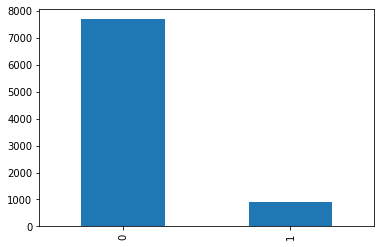

In [12]:
df = pd.DataFrame({"ALARM_SEQ":wba124.X_seq, "TARGET":wba124.major_down_arr})
df["TARGET"].value_counts().plot(kind="bar")

In [39]:
len_alarms = int(np.mean(df["ALARM_SEQ"].apply(lambda x:len(x))))
features = pad_sequences(df.ALARM_SEQ.values, maxlen=len_alarms, value=0, 
                         truncating='pre', padding='pre') 

In [46]:
X_train, X_test, y_train, y_test = train_test_split(features, df["TARGET"].values, test_size=0.3)

In [47]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [50]:
from sklearn.svm import SVC

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
rs = RandomizedSearchCV(SVC(),param_grid,refit=True,verbose=2)
rs.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ....................C=10, gamma=0.1, kernel=sigmoid; total time=   0.3s
[CV] END ....................C=10, gamma=0.1, kernel=sigmoid; total time=   0.3s
[CV] END ....................C=10, gamma=0.1, kernel=sigmoid; total time=   0.3s
[CV] END ....................C=10, gamma=0.1, kernel=sigmoid; total time=   0.3s
[CV] END ....................C=10, gamma=0.1, kernel=sigmoid; total time=   0.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   1.3s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   1.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   1.2s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   1.2s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   1.4s
[CV] END .......................C=100, gamma=0.1

RandomizedSearchCV(estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 10, 100],
                                        'gamma': [1, 0.1, 0.01, 0.001],
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   verbose=2)

In [51]:
pred = rs.predict(X_test)

confusion_matrix(y_test, pred)

array([[2301,    2],
       [ 274,    4]])

# Deep learning solution

In [52]:
encoded_X_seq, n_alarms, mapping_dict = label_encode(wba124.X_seq)